In [1]:
%%capture
!pip install langchain==0.1.16
!pip install transformers==4.41.2
!pip install huggingface-hub==0.23.4
!pip install sentence-transformers==2.5.1
!pip install chromadb
!pip install wget==3.2
!pip install --upgrade torch --index-url https://download.pytorch.org/whl/cpu
!pip install langchain-huggingface

In [2]:
!pip install sentence-transformers

In [3]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.17.0 scikit-learn==1.6.1

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.5 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.3
    Uninstalling joblib-1.5.3:
      Successfully uninstalled joblib-1.5.3

In [4]:
!pip install langchain-huggingface

In [1]:
def warn(*args,**kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [2]:
from langchain_community.document_loaders import TextLoader

from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.vectorstores import Chroma

from langchain_core.runnables import RunnablePassthrough

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

from langchain_huggingface import HuggingFacePipeline

In [3]:
filename="/content/companyPolicies.txt"
file=open(filename, mode='r')
text=file.read()
text

"1.\tCode of Conduct\n\nOur Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.\nIntegrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest.\nRespect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy.\nAccountability: We take responsibility for our actions and decisions. We follow all relevant laws and regulations, and we strive to continuously improve our practices. We report any potential violati

In [4]:
import re

pattern = r"\n?\s*(\d+\.\s+[^\n]+)\n+"
parts = re.split(pattern, text)

sections = []
for i in range(1, len(parts), 2):
    title = parts[i].strip()
    body = parts[i+1].strip()

    full_section = title + "\n" + body

    # VERY IMPORTANT: drop anything that is too small
    if len(full_section) > 300:
        sections.append(full_section)

In [5]:
len(sections)

9

In [6]:
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)

docs = []
for sec in sections:
    docs.extend(splitter.create_documents([sec]))

In [7]:
len(docs)

44

In [8]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [9]:
docsearch = Chroma.from_documents(
    docs,
    embeddings,
    collection_name="company_policy_v2"
)

In [ ]:
docs_with_scores = docsearch.similarity_search_with_score("what is the code of conduct", k=4)

docs_with_scores.sort(key=lambda x: x[1])

docs = [doc for doc, _ in docs_with_scores[:3]]

In [ ]:
docs_with_scores

[(Document(metadata={}, page_content='1.\tCode of Conduct\nOur Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.'),
  0.3570346534252167),
 (Document(metadata={}, page_content="Environmental Responsibility: We are committed to minimizing our environmental footprint and promoting sustainable practices.\nOur Code of Conduct is not just a set of rules; it is the foundation of our organization's culture. We expect all employees to uphold these principles and serve as role models for others, ensuring we maintain our reputation for ethical conduct, integrity, and social responsibility."),
  1.2375195026397705),
 (Document(metadata={}, page_content='Review and Update: This policy is subject to regular review and update to remain aligned with evolving legal requirements and best practices in preventing discrimination and haras

In [ ]:
docs

[Document(metadata={}, page_content='1.\tCode of Conduct\nOur Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability.'),
 Document(metadata={}, page_content="Environmental Responsibility: We are committed to minimizing our environmental footprint and promoting sustainable practices.\nOur Code of Conduct is not just a set of rules; it is the foundation of our organization's culture. We expect all employees to uphold these principles and serve as role models for others, ensuring we maintain our reputation for ethical conduct, integrity, and social responsibility."),
 Document(metadata={}, page_content='Review and Update: This policy is subject to regular review and update to remain aligned with evolving legal requirements and best practices in preventing discrimination and harassment. This organization considers it a collectiv

In [ ]:
QA_PROMPT = """
You must answer the question ONLY using the context below.

Rules:
- Every sentence must include a citation like [Doc X].
- Do NOT use outside knowledge.
- If the answer is not present, say:
"I don't know based on the provided documents."

Context:
{context}

Question:
{question}

Answer:
"""

In [ ]:
import torch
model_id = "Qwen/Qwen2.5-7B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    resume_download=True,
    use_safetensors=True
)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=120,
    do_sample=True,
    temperature=0.7,
    return_full_text=False
)
llm = HuggingFacePipeline(pipeline=pipe)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/663 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.56G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

In [ ]:
llm.generate(
    ["Summarize supervised vs unsupervised learning in 5 bullet points"]
)

LLMResult(generations=[[Generation(text=' and provide a comparison of their pros and cons. #1: Supervised Learning\nSupervised learning is a type of machine learning where the algorithm is trained on labeled data to learn a mapping between inputs and outputs. The goal is to find a function that maps the input data to the output data accurately and without any noise or errors in the data. Supervised learning is often used when the output is known, such as in classification problems.\n\nPros:\n- Accurate predictions\n- Can handle large datasets\n- Can handle complex relationships between inputs and outputs\n\nCons:\n- Requires labeled data\n- Can')]], llm_output=None, run=[RunInfo(run_id=UUID('019c1349-8e56-75c2-88a1-47bf636de574'))], type='LLMResult')

In [ ]:
docs = docsearch.similarity_search_with_score("what is the recruitment policy?", k=2)
docs

[(Document(metadata={}, page_content='Our Recruitment Policy is a foundation for creating a diverse, inclusive, and talented workforce. It ensures that we attract and hire the best candidates who align with our company values and contribute to our continued success. We continuously review and update this policy to reflect evolving best practices in recruitment.'),
  0.4546263813972473),
 (Document(metadata={}, page_content='2.\tRecruitment Policy\nOur Recruitment Policy reflects our commitment to attracting, selecting, and onboarding the most qualified and diverse candidates to join our organization. We believe that the success of our company relies on the talents, skills, and dedication of our employees.'),
  0.5007368326187134)]

In [ ]:
def answer_question(question: str):
    docs_with_scores = docsearch.similarity_search_with_score(question, k=2)
    docs_with_scores.sort(key=lambda x: x[1])

    docs = [doc for doc, _ in docs_with_scores]

    context = "\n\n".join(
        f"[Doc{i+1}] {doc.page_content.strip()}"
        for i, doc in enumerate(docs)
    )

    answer = llm.invoke(QA_PROMPT.format(
        context=context,
        question=question
    ))

    return answer.strip()

In [ ]:
import gradio as gr

with gr.Blocks(title="Company Policy QA Assistant") as demo:
    gr.Markdown(
        """
        ## Company Policy Question Answering
        Ask questions about company policies.
        Answers are generated **strictly from the documents**.
        """
    )

    with gr.Row():
        question_input = gr.Textbox(
            label="Ask a question",
            placeholder="e.g. What is the recruitment policy?",
            lines=2
        )

    answer_output = gr.Textbox(
        label="Answer",
        lines=6,
        interactive=False
    )

    submit_btn = gr.Button("Get Answer")

    submit_btn.click(
        fn=answer_question,
        inputs=question_input,
        outputs=answer_output
    )

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f546cb592af678dfa8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
import pandas as pd

data = [
    {"policy": "Code of Conduct", "question": "What are the core principles outlined in the Code of Conduct?",
     "answer": "The core principles are integrity, respect, accountability, safety, and environmental responsibility."},

    {"policy": "Code of Conduct", "question": "What does integrity mean according to the Code of Conduct?",
     "answer": "Integrity means acting honestly and transparently, protecting sensitive information, and avoiding conflicts of interest."},

    {"policy": "Recruitment Policy", "question": "Does the organization follow an equal opportunity recruitment process?",
     "answer": "Yes, the organization is an equal opportunity employer and does not discriminate based on protected characteristics."},

    {"policy": "Internet and Email Policy", "question": "Is personal use of company internet and email allowed?",
     "answer": "Limited personal use is allowed during non-work hours as long as it does not interfere with work responsibilities."},

    {"policy": "Mobile Phone Policy", "question": "What should an employee do if a mobile device is lost or stolen?",
     "answer": "The employee must immediately report it to the IT department or their supervisor."},

    {"policy": "Smoking Policy", "question": "Where is smoking permitted on company premises?",
     "answer": "Smoking is only permitted in designated smoking areas marked by appropriate signage."},

    {"policy": "Drug and Alcohol Policy", "question": "Is alcohol consumption allowed during work hours?",
     "answer": "Alcohol consumption is not allowed during work hours or on company property, except for company-sanctioned events."},

    {"policy": "Health and Safety Policy", "question": "Who is responsible for maintaining workplace health and safety?",
     "answer": "Every individual within the organization is responsible for upholding health and safety standards."},

    {"policy": "Anti-Discrimination Policy", "question": "How should incidents of harassment be reported?",
     "answer": "Incidents should be reported to a supervisor, manager, or designated HR representative."},

    {"policy": "Discipline and Termination Policy", "question": "What disciplinary actions can the organization take?",
     "answer": "Actions may include verbal warnings, written warnings, suspension, or other appropriate measures."}
]

df = pd.DataFrame(data)
df

,policy,question,answer
0,Code of Conduct,What are the core principles outlined in the C...,"The core principles are integrity, respect, ac..."
1,Code of Conduct,What does integrity mean according to the Code...,Integrity means acting honestly and transparen...
2,Recruitment Policy,Does the organization follow an equal opportun...,"Yes, the organization is an equal opportunity ..."
3,Internet and Email Policy,Is personal use of company internet and email ...,Limited personal use is allowed during non-wor...
4,Mobile Phone Policy,What should an employee do if a mobile device ...,The employee must immediately report it to the...
5,Smoking Policy,Where is smoking permitted on company premises?,Smoking is only permitted in designated smokin...
6,Drug and Alcohol Policy,Is alcohol consumption allowed during work hours?,Alcohol consumption is not allowed during work...
7,Health and Safety Policy,Who is responsible for maintaining workplace h...,Every individual within the organization is re...
8,Anti-Discrimination Policy,How should incidents of harassment be reported?,"Incidents should be reported to a supervisor, ..."
9,Discipline and Termination Policy,What disciplinary actions can the organization...,"Actions may include verbal warnings, written w..."


In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def cos_sim(a, b):
    return cosine_similarity(
        np.array(a).reshape(1, -1),
        np.array(b).reshape(1, -1)
    )[0][0]

In [34]:
from sentence_transformers import SentenceTransformer
THRESHOLD = 0.60
model = SentenceTransformer("all-MiniLM-L6-v2")
correct = 0

for i in range(len(df)):
    question = df.iloc[i]["question"]
    gt_answer = df.iloc[i]["answer"]

    docs_with_scores = docsearch.similarity_search(question, k=3)

    gt_emb = model.encode(gt_answer)

    best_sim = 0

    for doc in docs_with_scores:
        doc_emb = model.encode(doc.page_content)
        sim = cos_sim(gt_emb, doc_emb)
        best_sim = max(best_sim, sim)

    if best_sim >= THRESHOLD:
        correct += 1

accuracy = correct / len(df)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 80.00%


In [28]:
sims = []

for i in range(len(df)):
    question = df.iloc[i]["question"]
    gt_answer = df.iloc[i]["answer"]
    docs = docsearch.similarity_search(question, k=3)

    gt_emb = model.encode(gt_answer)

    for doc in docs:
        sim = cos_sim(gt_emb, model.encode(doc.page_content))
        sims.append(sim)

print(sims)

[0.46128893, 0.5264441, 0.54313517, 0.43097836, 0.82995164, 0.48801106, 0.6259649, 0.2214971, 0.21455884, 0.61303574, 0.3007745, 0.3058712, 0.2720992, 0.28425324, 0.18052748, 0.84112465, 0.61151683, 0.48418936, 0.76265275, 0.56779534, 0.40911028, 0.7181008, 0.51366854, 0.65402305, 0.7667719, 0.41757584, 0.48493516, 0.68597484, 0.4678735, 0.4512987]


In [29]:
print(min(sims),max(sims))

0.18052748 0.84112465


In [36]:
c=[]
for t in [0.5, 0.55, 0.6, 0.65, 0.7]:
    correct = 0
    for i in range(len(df)):
        gt = df.iloc[i]["answer"]
        docs = docsearch.similarity_search(df.iloc[i]["question"], k=3)
        gt_emb = model.encode(gt)

        best = max(
            cos_sim(gt_emb, model.encode(doc.page_content))
            for doc in docs
        )

        if best >= t:
            correct += 1
    c.append(correct)
    print(f"Threshold {t}: {correct/len(df):.2%}")

Threshold 0.5: 90.00%
Threshold 0.55: 80.00%
Threshold 0.6: 80.00%
Threshold 0.65: 60.00%
Threshold 0.7: 50.00%


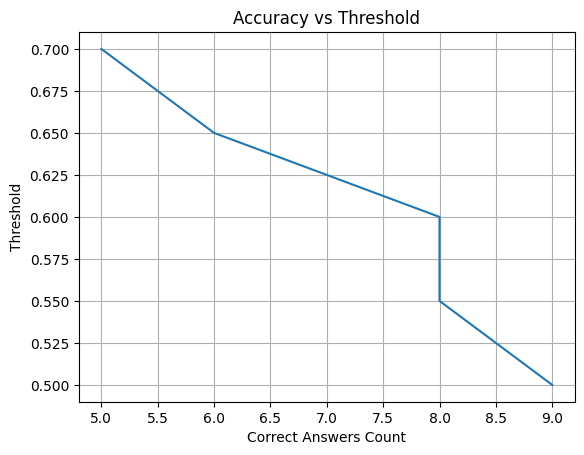

In [40]:
import matplotlib.pyplot as plt
import numpy as np
c_arr = np.array(c)
t_values = np.array([0.5, 0.55, 0.6, 0.65, 0.7])
plt.plot(c_arr, t_values)
plt.xlabel("Correct Answers Count")
plt.ylabel("Threshold")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()